In [1]:
import numpy as np
from PIL import Image
import pandas as pd
import os


In [2]:
%%time

# Loads filenames, images and labels 
# Reshapes images to (80, 80, 3)

def load_data(name):
    df = pd.read_csv(name + '.csv')
    df_sorted = df.sort_values(by='image_id')

    labelDict = dict()
    labels = df_sorted.values
    for entry in labels:
        try:
            labelDict[entry[0]] = entry[1]
        except:
            labelDict[entry[0]] = 0

    images = []
    labels = []
    filenames = []
    for filename in os.listdir(name):
        if filename.endswith('.png'):
            file_path = os.path.join(name, filename)
            image = Image.open(file_path)
            image_array = np.array(image)
            if filename[:-4] in labelDict.keys():
                filenames.append(filename[:-4])
                images.append(image_array)
                labels.append(labelDict[filename[:-4]])

    for i in range(len(images)):
        if images[i].shape != (80, 80, 3):
            images[i] = np.stack((images[i], images[i], images[i]), axis=-1)

    images = np.array(images)
    labels = np.array(labels)

    return filenames, images, labels

training_filenames, training_images, training_labels = load_data("train")
print(f"Training: {np.shape(training_images)} - {np.shape(training_labels)}")

validation_filenames, validation_images, validation_labels = load_data("validation")
print(f"Validation: {np.shape(validation_images)} - {np.shape(validation_labels)}")

test_filenames, test_images, test_labels = load_data("test")
print(f"Test: {np.shape(test_images)} - {np.shape(test_labels)}")

Training: (10500, 80, 80, 3) - (10500,)
Validation: (3000, 80, 80, 3) - (3000,)
Test: (4500, 80, 80, 3) - (4500,)
CPU times: user 4.37 s, sys: 573 ms, total: 4.94 s
Wall time: 4.94 s


In [5]:
# Standardize images

standard_training_images = (training_images - np.mean(training_images, axis=(0, 1, 2)))  / np.std(training_images, axis=(0, 1, 2))
standard_validation_images = (validation_images - np.mean(validation_images, axis=(0, 1, 2)))  / np.std(validation_images, axis=(0, 1, 2))
standard_test_images = (test_images - np.mean(test_images, axis=(0, 1, 2)))  / np.std(test_images, axis=(0, 1, 2))

In [ ]:
def to_grayscale(images):
    return np.mean(images, axis=(3))

gray_training_images = to_grayscale(training_images)
gray_validation_images = to_grayscale(validation_images)
gray_test_images = to_grayscale(test_images)

In [3]:
def save_images_by_label(filenames, images, labels, name):
    count = 0;
    for filename, image, label in zip(filenames, images, labels):
        Image.fromarray(image.astype(np.uint8)).save(f"{name}{str(label)}/{filename}.png")
        count += 1
    print(count)

save_images_by_label(training_filenames, mono_training_images, training_labels, "mono-train")

NameError: name 'mono_training_images' is not defined

In [ ]:
# Keep only the strongest color for each pixel
def keep_strongest_color(rgb) :
    c = np.argmax(rgb)
    for i in range(3):
        if i != c:
            rgb[i] = 0
    return rgb

def process_images(images):
    for i in range(len(images)):
        if i % 500 == 0:
            print(i)
        for j in range(len(images[i])):
            for k in range(len(images[i][j])):
                images[i][j][k] = keep_strongest_color(images[i][j][k])
    return images
mono_training_images = process_images(training_images[:1000])
mino_validation_images = process_images(validation_images[:1000])
mono_test_images = process_images(test_images[:1000])
    

In [ ]:
def print_images(images, labels, count, cmap=None, title="title"):
    for i in range(count):
        plt.imshow(images[i], cmap=cmap)
        plt.title(f'Label: {labels[i]}')
        plt.show()

        img = images[i]
        # mins = np.min(img, axis=(0, 1))
        # maxs = np.max(img, axis=(0, 1))
        # img = (img - mins) / (maxs - mins) * 255.0
        Image.fromarray(img.astype(np.uint8)).save(f"documentation/plots/{title}-{labels[i]}-{str(i)}.png")

In [ ]:
print_images(standard_training_images, training_labels, 5, title="standard")

In [ ]:

print_images(gray_training_images, training_labels, 5, cmap='gray', title="gray")

In [ ]:

print_images(mono_training_images, training_labels, 5, title="mono")

In [ ]:
%%time
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
flat_training_images = scaler.fit_transform(mono_training_images.reshape((10500, 80*80*3)))
flat_validation_images = scaler.fit_transform(mino_validation_images.reshape((3000, 80*80*3)))


from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(flat_training_images, training_labels)
score = str(mnb.score(flat_validation_images, validation_labels))
print("score on test: " + str(score))

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

model_train_images = standard_training_images[:1000]
model_train_labels = to_categorical(training_labels[:1000], num_classes=3)
model_validation_images = standard_validation_images[:200]
model_validation_labels = to_categorical(validation_labels[:200], num_classes=3)

trainining_datagen = ImageDataGenerator(
    # rotation_range=10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # fill_mode='reflect'
)
trainining_datagen.fit(model_train_images)

validation_datagen = ImageDataGenerator(
    rotation_range=10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    fill_mode='reflect'
)
validation_datagen.fit(model_validation_images)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/tmp/checkpoint.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# my_model = Sequential([
#     Conv2D(128, (3, 3), activation='relu', input_shape=(80, 80, 3)),
#     MaxPooling2D(2, 2),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Conv2D(256, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Conv2D(256, (3, 3), activation='relu'),
#     Flatten(),
#     Dense(1024, activation='relu'),
#     Dense(3, activation='softmax')
# ])
my_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(80, 80, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])
my_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
my_model.summary()

history = my_model.fit(
    trainining_datagen.flow(model_train_images, model_train_labels, batch_size=32),
    epochs=30,
    validation_data=validation_datagen.flow(model_validation_images, model_validation_labels),
    callbacks=[model_checkpoint_callback],
)

loss, accuracy = my_model.evaluate(model_validation_images, model_validation_labels)
print(f'Validation accuracy: {accuracy}')

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_119 (Conv2D)             │ (None, 78, 78, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 76, 76, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 36, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,435 (10.14 MB)

 Trainable params: 2,658,435 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
26/32 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - accuracy: 0.3575 - loss: 1.1555

In [ ]:
%%time
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import skimage.measure

reduced_training_images = (skimage.measure.block_reduce(gray_training_images, (1,2,2), np.max)).reshape((10500, 40*40))
print(np.shape(reduced_training_images))
reduced_validation_images = (skimage.measure.block_reduce(gray_validation_images, (1,2,2), np.max)).reshape((3000, 40*40))

clf = svm.SVC(decision_function_shape='ovr', verbose=True, max_iter=-1, kernel="rbf", C=1)
clf.fit(reduced_training_images, training_labels)
score = clf.score(reduced_validation_images, validation_labels)

print("score on test: " + str(score))

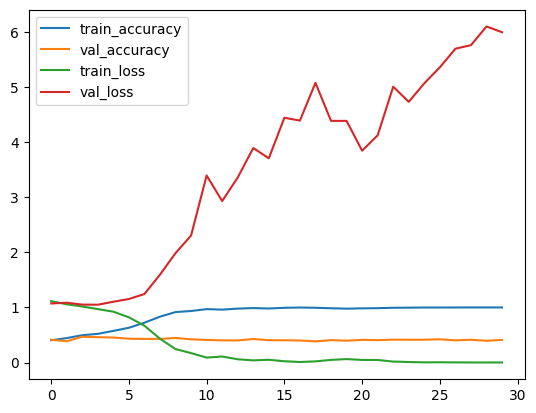

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.savefig("documentation/plots/cnn-1-3")
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(model, images, labels):
    y_prediction = model.predict(images)
    y_prediction = np.argmax (y_prediction, axis = 1)
    result = confusion_matrix(labels, y_prediction , normalize='pred')
    print(result)

print_confusion_matrix(my_model, validation_images, validation_labels)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
[[0.4        0.31082654 0.35772358]
 [0.25714286 0.36845169 0.29087624]
 [0.34285714 0.32072177 0.35140018]]
